### This notebook explains the part 2 of this assignment which is Optical Character Recognition

# 0) Dependencies

In [24]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import os
import glob
from matplotlib.pylab import rcParams

In [25]:
import pytesseract
from PIL import Image

In [26]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Help Functions

In [27]:
'''This function shows the image with converting from BGR to RGB because opencv read images as RGB'''

def imshow(image, cmap=None):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [111]:
'''This function equalizes the histogram'''

def histogram_equalizer(image, limit=2.0):
    
    ## CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit= limit, tileGridSize=(8,8))
    cl1 = clahe.apply(image)
    
    return cl1

In [226]:
'''This function finds the most plate-like contour'''

def find_plate(image):
    # use thresholding to isolate the plate
    (_,thresh) = cv2.threshold(image, 60, 255,cv2.THRESH_BINARY)

    # find the contours of the thresholded image
    (cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # sort the contours by size
    srt_cnts =  sorted(cnts, key=cv2.contourArea, reverse=True)
    # find the aspect ratio of each of the four largest contours to eliminate any with
    # the wrong shape
    bestContour = []
    for (i,c) in enumerate(srt_cnts[:4]):
        (x,y,w,h) = cv2.boundingRect(c)
        aspectRatio = w / float(h)
        if 1.5 <= aspectRatio <= 2.5:
            bestContour = srt_cnts[i]
            break

    # create a mask to isolate the plate area
    mask = np.zeros((img_height, img_width), np.uint8)
    cv2.fillConvexPoly(mask, bestContour, 1)
    masked_img = cv2.bitwise_and(image, image, mask=mask)


    # fill mask in with white
    mask2 = np.zeros((img_height+2, img_width+2), np.uint8)
    seed = (0,0)
    cv2.floodFill(masked_img, mask2, seed, (255,255,255))
    
    x,y,w,h = cv2.boundingRect(bestContour)

    plate_crop = masked_img[y+2:y+h-2,x+5:x+w-5]
    plate_crop = cv2.GaussianBlur(plate_crop, ksize=(3,3), sigmaX=0)
    
    plate_thresh = cv2.adaptiveThreshold(plate_crop, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 7)


    
    return plate_thresh

In [227]:
''' This function applies the radon transform to the image to correct the angle. '''
def radon_straighten(image):
    
    from skimage.transform import radon, rotate
    from skimage import img_as_ubyte
    
    orig_image = image.copy()
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    width, height = image.shape
    image = cv2.resize(image,(int(height*180/width),180))
    
    image = image - np.mean(image)
    theta = np.linspace(0,180,image.shape[1], endpoint=False)
    sinogram = radon(image, theta=theta, circle=True)
    rim = sum(abs(sinogram))
    ang = np.argmax(rim)
    angs = np.linspace(0, 180, len(rim))
    principal_ang = angs[int(ang)] - 90
    
    image_rotated = rotate(orig_image, -principal_ang, resize=True, cval=1)
    
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        image_rotated_uint8 = img_as_ubyte(image_rotated)
        
    image_rotated_uint8 = cv2.resize(image_rotated_uint8,(height,width))
    #image_rotated_uint8 = cv2.cvtColor(image_rotated_uint8, cv2.COLOR_BGR2GRAY)

    return image_rotated_uint8

In [228]:
''' This function applies the motion blur to an image to remove the noises. '''
def NoiseRemoval(image):

    # blurr size
    size = 5000

    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size

    # applying the kernel to the input image
    output = cv2.filter2D(image, -1, kernel_motion_blur)

    # Creating copies of the original images
    output_cp = output.copy()
    img_cp = plate_thresh.copy()

    # threshold
    ret,thresh = cv2.threshold(output_cp, 215, 255, cv2.THRESH_BINARY_INV)

    # find the contours of the thresholded image
    (cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    img_cnt = cv2.drawContours(image.copy(), cnts, 0, (0,255,0), -1)

    mask = np.zeros(image.shape, np.uint8)
    largest_area = sorted(cnts, key=cv2.contourArea, reverse=True)[0]

    p1 = largest_area[0]-2
    p2 = largest_area[1]
    p3 = largest_area[2]
    p4 = largest_area[3]-2

    largest_area = np.vstack([p1,p2,p3,p4])

    mask_cnt = cv2.drawContours(mask.copy(), [largest_area], 0, (255,255,255,255), -1)

    removed = cv2.subtract(mask_cnt, image)

    return removed

In [230]:
'''after we preprocess the image, we applied some more effects to help tesseract for reading.'''
def after_process(image):
    img_result = histogram_equalizer(image, 10)
    img_result = cv2.GaussianBlur(removed, ksize=(3,3), sigmaX=0)
    _, img_result = cv2.threshold(removed, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=3, bottom=3, left=3, right=3, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    
    return img_result

In [231]:
'''This function utilizes tesseract to recognize characters'''
def plate_to_string(img):


    plate_OCR = Image.fromarray(img)
    
    
    plate_text = pytesseract.image_to_string(plate_OCR, config='-c tessedit_char_whitelist=/xX0123456789 --psm=7')
    
    print (plate_text)

# Step-by-Step Process

## 1) Load Data

height: 80, width: 280


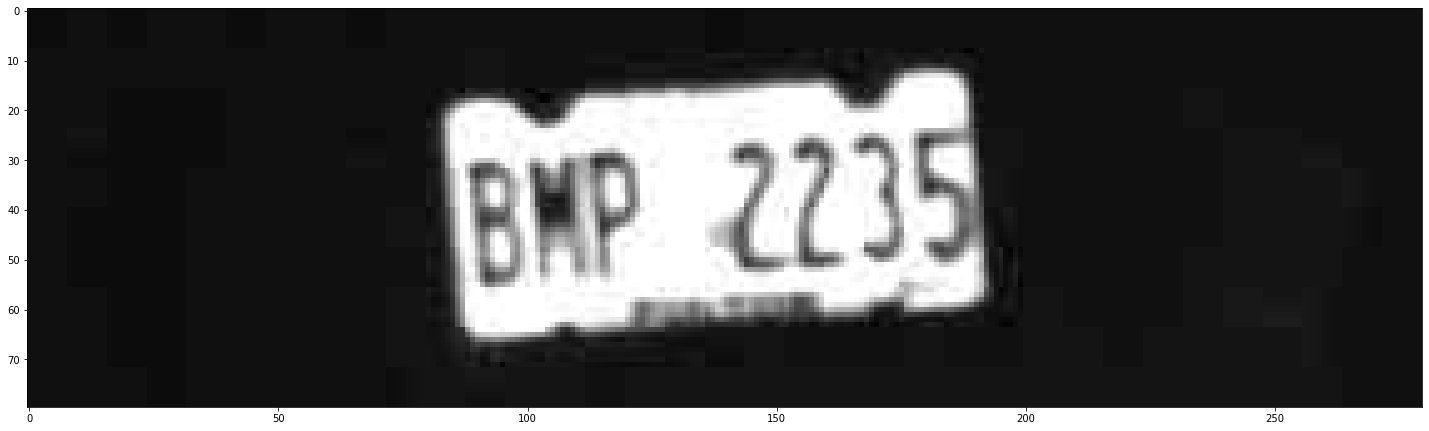

In [495]:
image_path = 'D:\\OneDrive - Georgia State University\\MSA\\Fall 2019\\MSA 8650 - Image and Text Analytics with Deep Neural Networks\\Assignments\\Assignment 1\\Data\\ir_patch\\'
from os import listdir
from os.path import isfile, join
data_list = [f for f in listdir(image_path) if isfile(join(image_path, f))]
#data_list = sorted(data_list, key=lambda x: float(x.split('.')[0]))


# load the image
number = 749 #444 #722 #91 #874 #850
image = cv2.imread(image_path + data_list[number]) # read as grayscale
img_height, img_width = image.shape[:2]
print(f'height: {img_height}, width: {img_width}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

rcParams['figure.figsize'] = 25, 12

imshow(image)

## 2a) Histogram Equalization

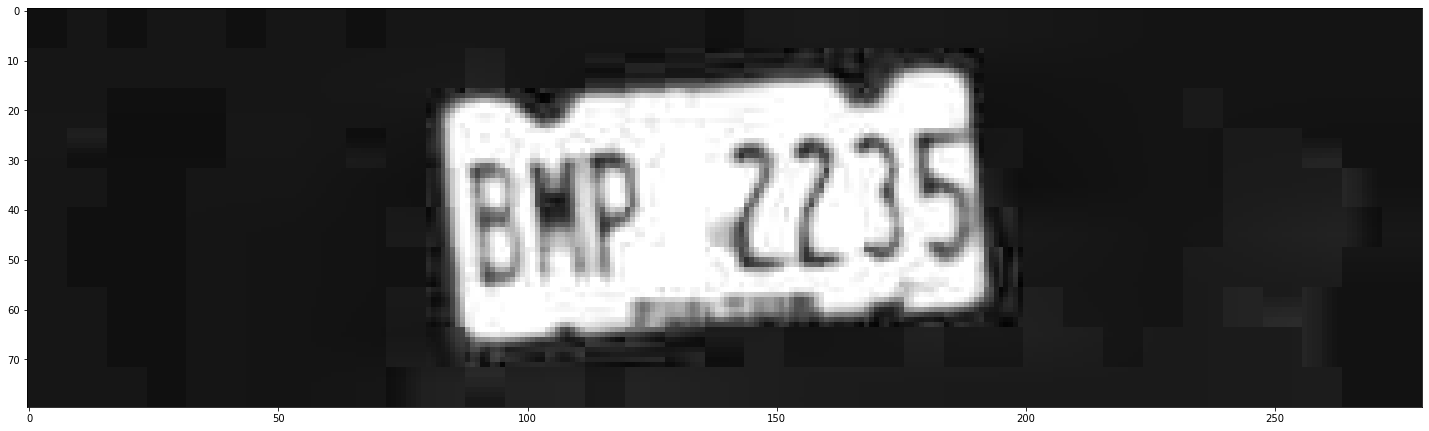

In [496]:
hist_equal = histogram_equalizer(image, 2)
imshow(hist_equal)

## 2b) Finds the plate contour and threshold it

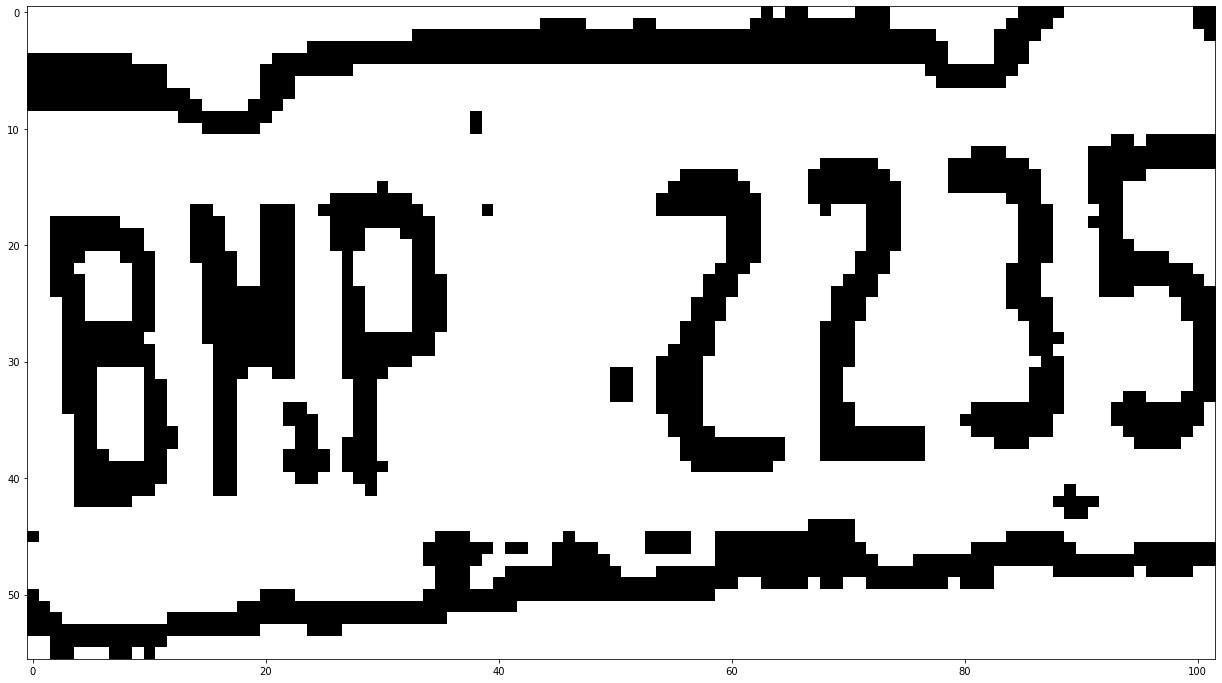

In [497]:
plate_thresh = find_plate(hist_equal)
imshow(plate_thresh)

## 2c) Applies radon transform to straighten the tilted image

D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


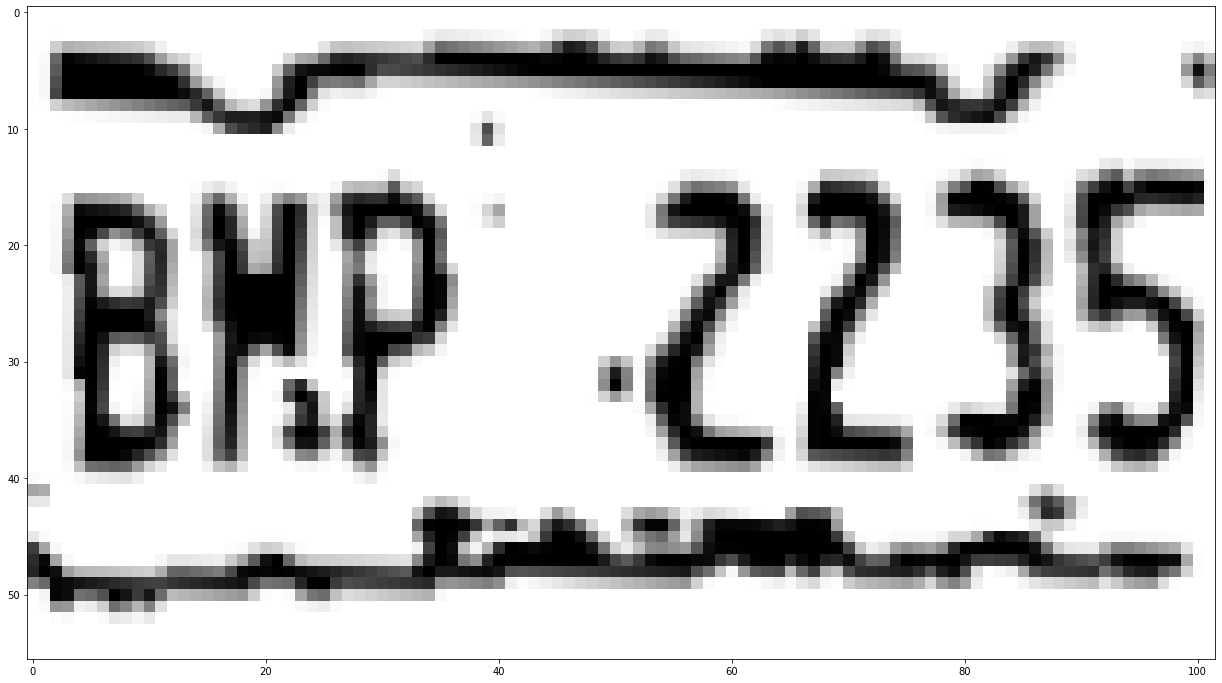

In [498]:
straightened = radon_straighten(plate_thresh)
imshow(straightened)

## 2d) Noise Removal

### First of all, we applied horizontal motion blur. It will show where the license plate numbers are aligned

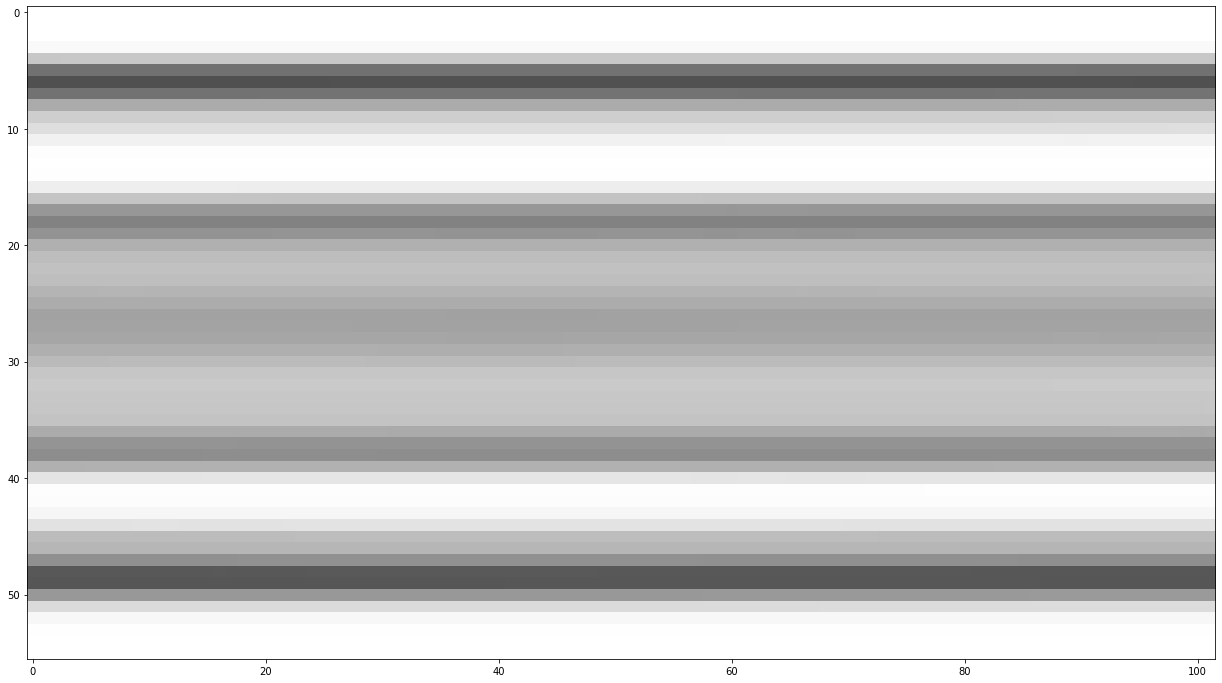

In [499]:
# blurr size
size = 5000

# generating the kernel
kernel_motion_blur = np.zeros((size, size))
kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
kernel_motion_blur = kernel_motion_blur / size

# applying the kernel to the input image
output = cv2.filter2D(straightened, -1, kernel_motion_blur)

imshow(output)


### Now if we threshold it, it will produce the image below

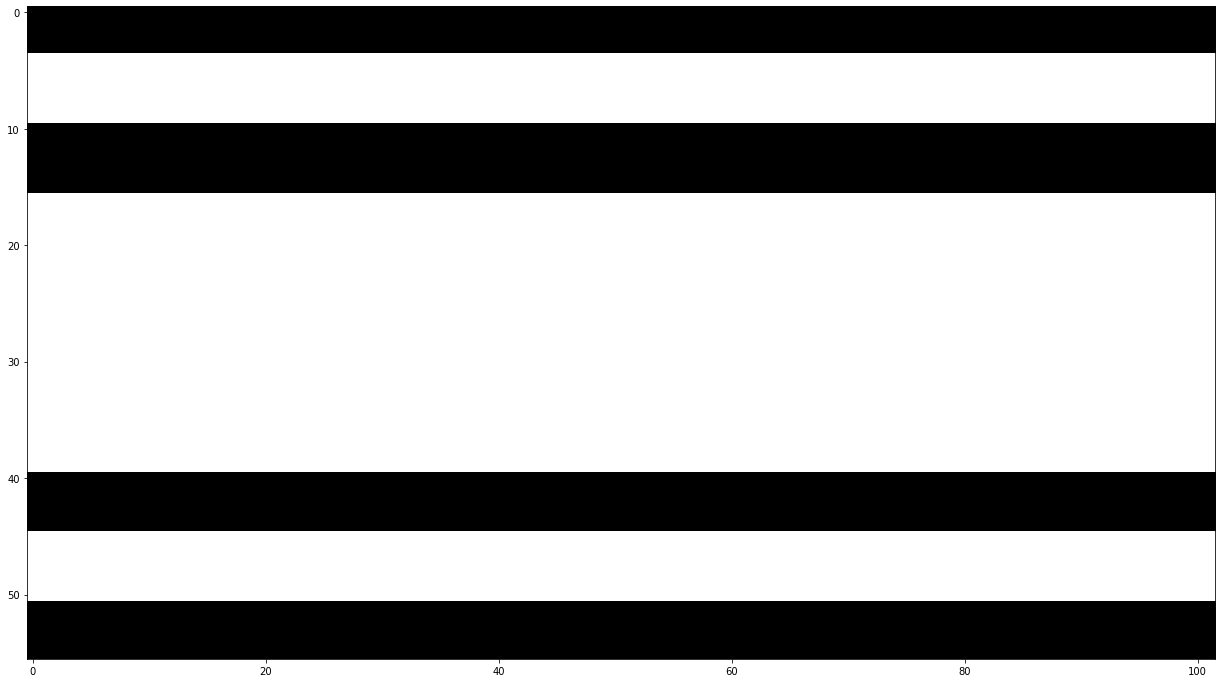

In [506]:
# Creating copies of the original images
output_cp = output.copy()
img_cp = straightened.copy()

# threshold
ret,thresh = cv2.threshold(output_cp, 215, 255, cv2.THRESH_BINARY_INV)

imshow(thresh)

## 2e) At this point, all we have to do is just to grap the biggest contour and mask it on the straightened image above.

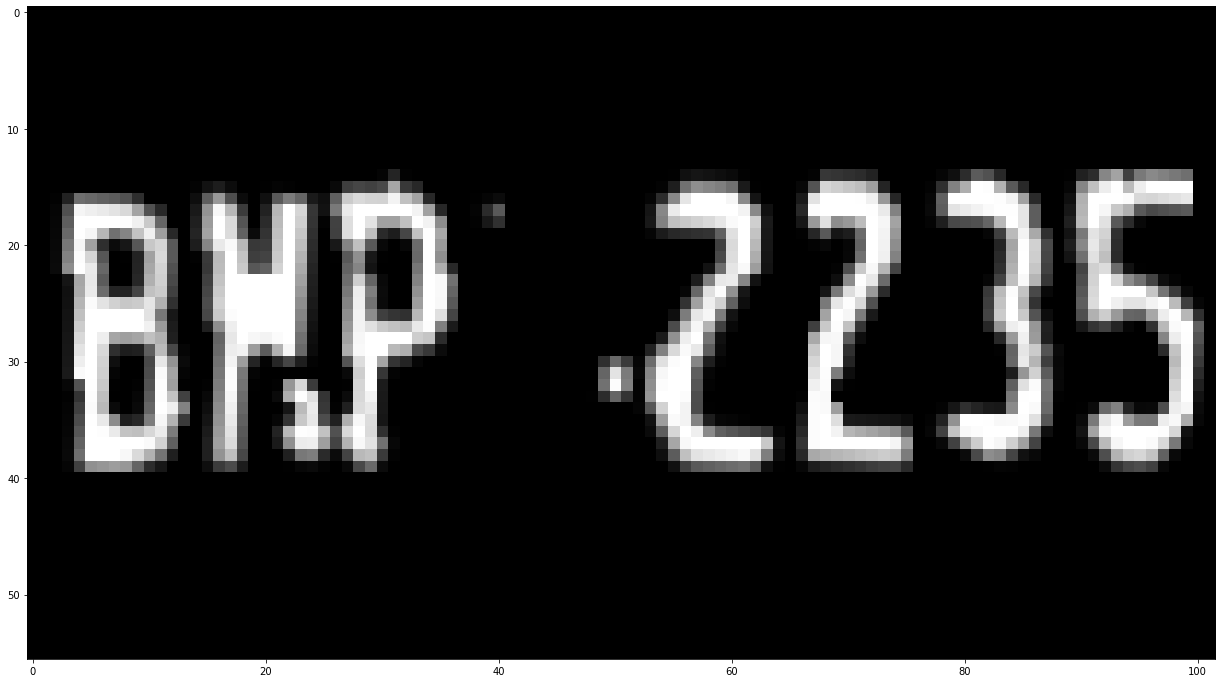

In [511]:
# find the contours of the thresholded image
(cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
img_cnt = cv2.drawContours(straightened.copy(), cnts, 0, (0,255,0), -1)

mask = np.zeros(straightened.shape, np.uint8)
largest_area = sorted(cnts, key=cv2.contourArea, reverse=True)[0]

p1 = largest_area[0]-2
p2 = largest_area[1]
p3 = largest_area[2]
p4 = largest_area[3]-2

largest_area = np.vstack([p1,p2,p3,p4])

mask_cnt = cv2.drawContours(mask.copy(), [largest_area], 0, (255,255,255,255), -1)

removed = cv2.subtract(mask_cnt, straightened)


plt.figure()
plt.imshow(removed, cmap='gray')

## 2f) After Process

###  I applied histogram equalization once more

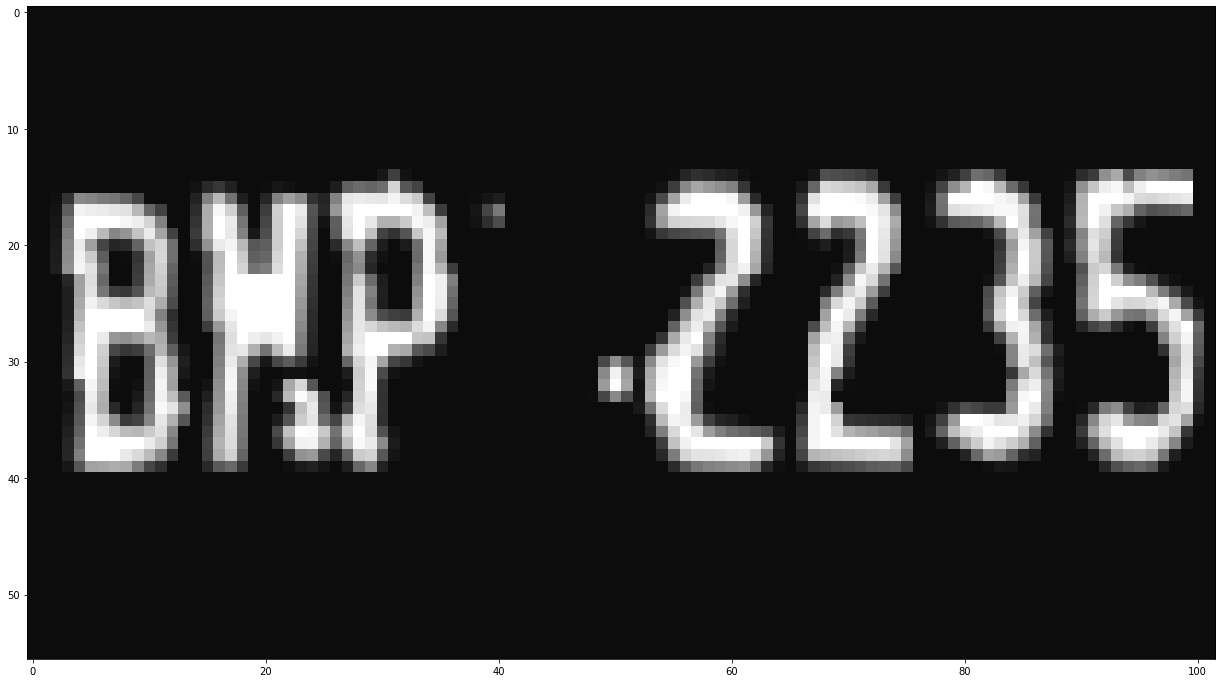

In [512]:
img_result = histogram_equalizer(removed, 10)
imshow(img_result)

### Next, I applied some more effects on the image to help tesseract to read more accurately

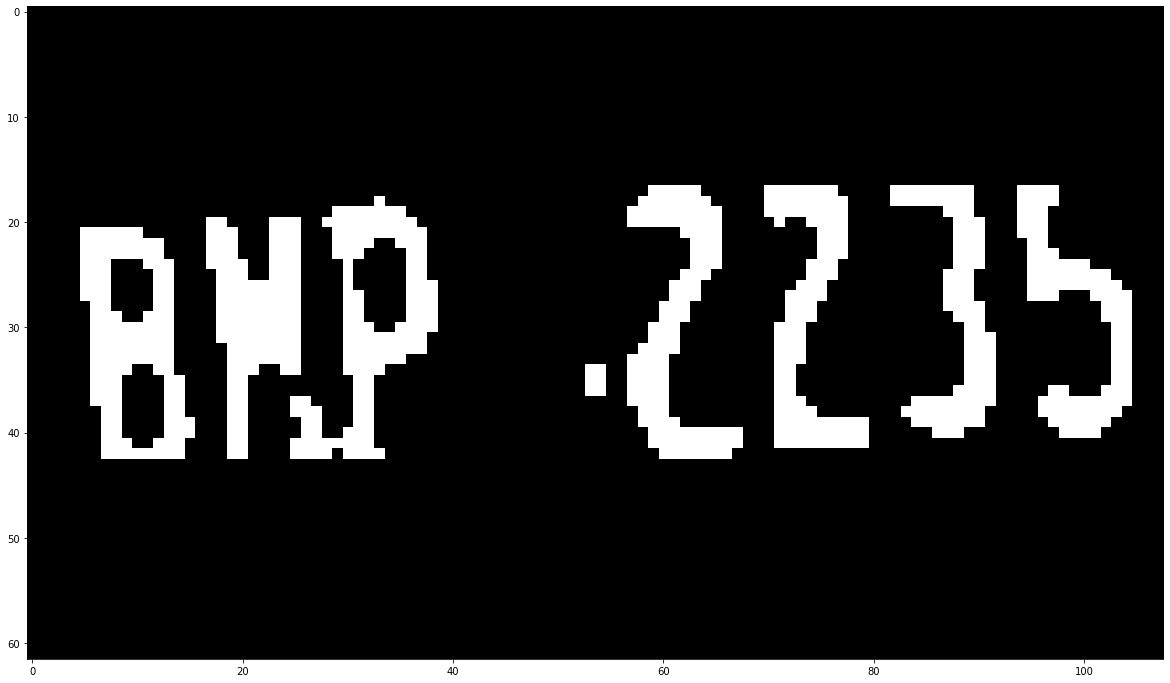

In [503]:
img_result = cv2.GaussianBlur(img_result, ksize=(3,3), sigmaX=0)
_, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)


img_result = cv2.copyMakeBorder(img_result, top=3, bottom=3, left=3, right=3, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
imshow(img_result)

## 2g) Finally, tesseract will recognize the characters.

### However, for some images, tesseract recognizes the character from an image in the middle of the process not the final output of the process.

### So, I put all the images in a list and loop the tesseract algorithm on each images. Then filter the strings with some filters to get the most license plate number-like string.

In [513]:
images = [image, plate_thresh, straightened, removed, img_result]
answer = []
for i,c in enumerate(images): 
    
    plate_OCR = Image.fromarray(c)
    plate_text = pytesseract.image_to_string(plate_OCR, config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 13')
    plate_text = ''.join(e for e in plate_text if e.isalnum())
    if len(plate_text)>=5:
        if plate_text not in answer:
            answer.append(plate_text)
    print(f'{i}: {plate_text}')
print(f'\n{answer}')

0: 
1: BMP2235
2: PE
3: E

['BMP2235']


# 3) Overall Process

### This is just the overall process.

height: 80, width: 280


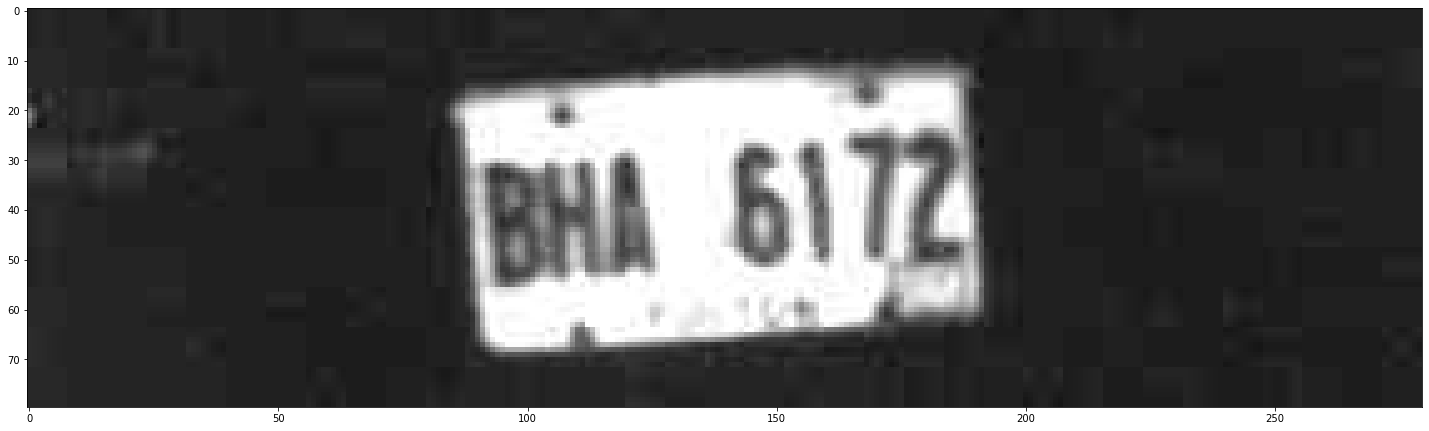

In [140]:
number = 0

image = cv2.imread(image_path + data_list[number]) 
img_height, img_width = image.shape[:2]
print(f'height: {img_height}, width: {img_width}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imshow(image)

D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


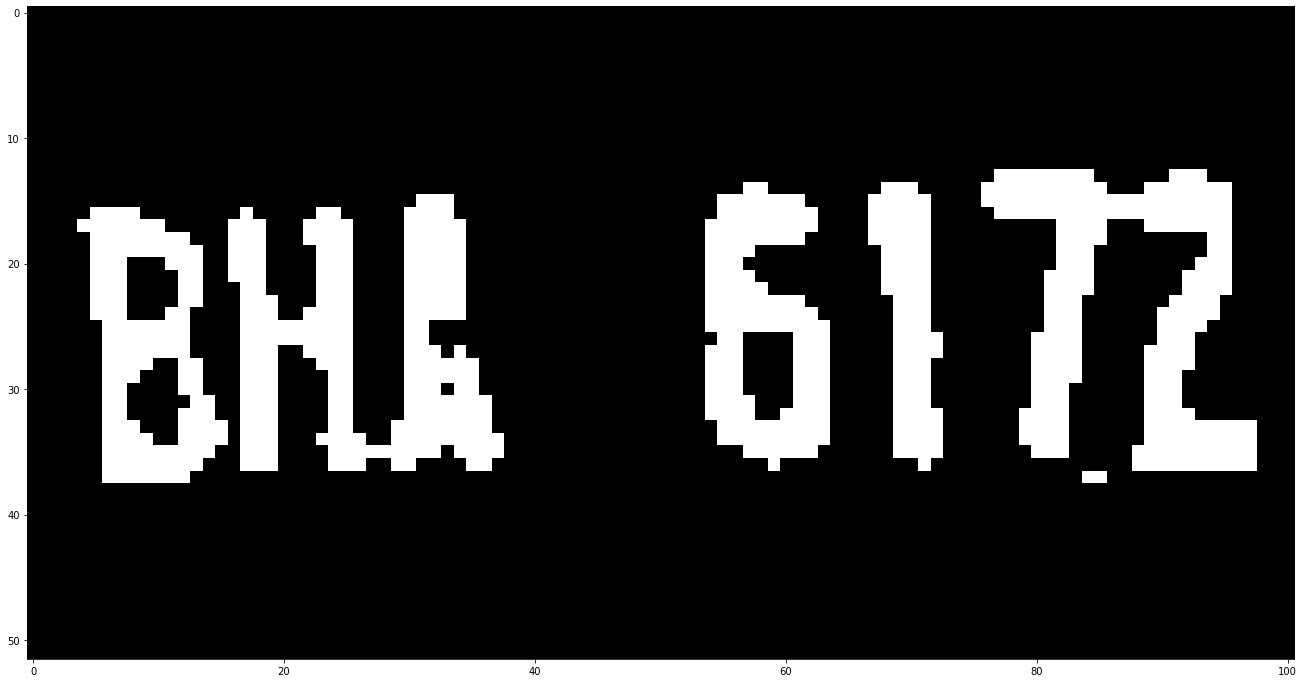

In [141]:
hist_equal = histogram_equalizer(image, 2)
straightened = radon_straighten(hist_equal)
plate_thresh = find_plate(straightened)
removed = NoiseRemoval(plate_thresh)
img_result = after_process(removed)

imshow(img_result)

In [148]:
images = [image, plate_thresh, straightened, removed, img_result]
answer = []
for i,c in enumerate(images): 
    
    plate_OCR = Image.fromarray(c)
    plate_text = pytesseract.image_to_string(plate_OCR, config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 13')
    plate_text = ''.join(e for e in plate_text if e.isalnum())
    if len(plate_text)>5:
        answer.append(plate_text)
    print(f'{i}: {plate_text}')
print(f'\n{answer}')

0: 
1: BBJ9033
2: 
3: PAIS
4: AE

['BBJ9033']


# 4) Run on a batch

In [143]:
# set the saving directory to specified path 

result_path = 'D:\\OneDrive - Georgia State University\\MSA\\Fall 2019\\MSA 8650 - Image and Text Analytics with Deep Neural Networks\\Assignments\\Assignment 1\\Results\\'

OCR_path = result_path + 'For_OCR\\'

In [145]:
image_path = 'D:\\OneDrive - Georgia State University\\MSA\\Fall 2019\\MSA 8650 - Image and Text Analytics with Deep Neural Networks\\Assignments\\Assignment 1\\Data\\ir_patch\\'
data_list = [f for f in listdir(image_path) if isfile(join(image_path, f))]
#data_list = sorted(data_list, key=lambda x: float(x.split('.')[0]))

count = 0
for i in data_list:
    #x = np.zeros([img_height,img_width])+255
    #cv2.imwrite(f'{segment_path}{count}.png', x)
    try:
        image = cv2.imread(image_path + i) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        hist_equal = histogram_equalizer(image, 2)
        straightened = radon_straighten(hist_equal)
        plate_thresh = find_plate(straightened)
        removed = NoiseRemoval(plate_thresh)
        img_result = after_process(removed)

        cv2.imwrite(f'{OCR_path}{count}.png', img_result)
    except:
        print(count)
    count += 1
    

D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

4


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

12


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


13


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


14


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


17


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


19


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

26


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


27


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

44


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

57


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


61


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

68


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


69


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

75


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


77


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


80


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


82


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


86


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


88


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

109


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


112


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


116


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


119


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

126


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


129


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


131


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


134


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

140


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


142


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


143


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

155


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


157


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

167


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

175


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


176


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

183


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

200


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


202


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

209


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

216


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

222


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


224


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


225


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

230


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

244


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


246


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


250


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

255


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


257


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


259


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

275


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

283


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


284


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


285


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


288


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


292


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


296


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


298


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


299


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

307


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


308


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


309


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


311


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


312


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


313


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


316


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


320


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

326


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

349


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


351


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

364


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

378


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

396


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


397


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


398


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

403


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


404


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

410


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

420


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


422


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

431


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

452


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

460


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

466


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


467


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


469


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

476


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

492


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

497


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

502


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


504


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


505


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

530


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

548


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

555


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

560


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

585


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


587


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

592


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


596


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

606


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


607


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

612


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

619


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


620


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

625


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


627


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


630


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


633


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


636


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


637


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


638


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

646


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

657


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


660


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


663


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


666


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


670


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

682


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


685


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

706


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

715


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

726


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

731


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

744


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


748


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


752


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

772


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

779


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

784


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

802


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

808


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

814


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


818


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


821


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


824


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

831


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


833


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

838


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

851


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


852


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


855


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


858


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


860


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

870


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

878


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


879


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


882


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


883


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


887


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


888


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


889


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

895


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


897


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

907


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

915


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


917


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


919


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


922


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

933


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


935


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


936


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

941


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

946


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

955


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

967


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


968


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


969


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

975


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


976


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


977


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

982


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


983


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


984


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

991


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


993


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


996


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1004


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1006


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1008


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1009


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1012


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1021


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1022


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1024


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1026


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1030


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1032


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1035


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1043


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1060


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1061


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1063


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1066


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1069


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1075


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1078


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1081


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1087


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1088


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1090


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1093


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1098


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1102


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1104


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1119


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1120


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1121


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1124


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1137


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1143


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1150


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1173


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1175


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1186


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1199


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1200


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1202


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1203


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1204


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1223


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1225


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1229


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1232


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1233


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1239


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1241


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1246


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1248


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1254


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1271


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1279


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1282


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1283


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1290


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1306


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1318


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1323


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1325


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1329


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1334


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1335


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1339


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1362


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1369


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1374


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1377


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1378


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1382


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1395


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1396


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1404


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1413


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1416


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1420


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1424


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1425


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1426


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1427


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1432


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1438


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1444


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1447


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1451


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1456


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1466


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1472


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1473


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1477


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1478


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1502


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1506


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1514


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1530


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1537


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1541


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1542


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1556


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1560


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1567


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1579


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1581


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1590


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1603


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1610


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1612


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1620


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1627


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1644


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1650


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1653


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1655


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1662


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1674


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1678


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1717


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1727


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1737


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1743


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1747


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1749


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1750


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1762


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1769


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1772


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1775


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1785


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1786


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1787


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1788


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1789


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1799


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1806


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1808


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage

1814


D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
D:\Programming\Anaconda\envs\image\lib\site-packages\skimage